# 📘 Introduction
This notebook is focused on building a classification model to predict income level. We know from earlier exploration that there's a class imbalance, with most people earning <=50K, so we’ll take that into account during modeling.

To handle the imbalance, we’ll consider:

* Using class_weight with Logistic Regression

We’ll also introduce a new feature:

* `net_capital`, which combines `capital_gain` and `capital_loss`

The following columns will not be included in the model due to redundancy or low correlation:

* `education` (since we’re using education_num)

* `relationship` (closely tied to marital_status)

* `fnlwgt` (low correlation with income)

For preprocessing, we’ll use `StandardScaler()` to normalize numerical features.

Initial models to explore:

* Logistic Regression and LightGBM (with class_weight)

* Ensemble models such as Random Forest, Gradient Boosting, and XGBoost — all of which can handle class imbalance well.

Use metrics like precision/recall or ROC-AUC which is important for imbalanced datasets


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/data/clean_adult_train.csv'
file_path2 = '/content/drive/MyDrive/Colab Notebooks/data/clean_adult_test.csv'






Mounted at /content/drive


In [ ]:
train = pd.read_csv(file_path)
test = pd.read_csv(file_path2)

In [ ]:
X = train.drop('income', axis = 1)
y = train['income']
y = y.map({'<=50K':0,'>50K':1})
y.dtypes

dtype('int64')

# Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_validate

Create a class that inherits from `BaseEstimator` and `ransromerMixin` and implements:
* `fit(self, X, y=None)` —  returns self
* `transform(self, X)` — modifies the DataFrame to add the net_capital column

In [ ]:

from sklearn.base import BaseEstimator, TransformerMixin

class NetCapitalAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['net_capital'] = X['capital_gain'] - X['capital_loss']
        return X


## Create Pipeline
In this step, we build the full preprocessing and modeling pipeline.
- `StandardScaler()` is applied to numeric features to normalize their scale.
- `OneHotEncoder()` is used for categorical (object) features to prepare them for modeling.
- `NetCapitalAdder()` is a custom transformer that adds a new feature, net_capital, by combining capital_gain and capital_loss.

This setup ensures all preprocessing and feature engineering is done within the pipeline, keeping the workflow clean and reproducible.

In [ ]:
# Define numeric and categorical preprocessors
numeric_preprocessor = Pipeline(
    steps = [("scaler", StandardScaler())]
)

cat_preprocessor = Pipeline(
    steps =[('onehot', OneHotEncoder())]
)

preprocessor = ColumnTransformer([
    ('cat',cat_preprocessor,['workclass','marital_status','occupation','race','sex','native_country']),
    ('num', numeric_preprocessor, ['age','education_num','capital_gain','capital_loss','hours_per_week','net_capital'])
])

# Wrap everything in a full pipeline
full_pipeline = Pipeline(steps=[
    ('add_net_capital', NetCapitalAdder()),   # Custom transformer goes here
    ('preprocessor', preprocessor)            # Then column-specific transformations
])

## Baseline models
Since this is a binary classification problem with a mix of categorical and numerical features, and mild class imbalance. The following models were chosen to provide a balance between interpretability, performance, and robustness:

**RandomForestClassifier**
* A strong, non-parametric ensemble method that handles mixed data types well and is robust to outliers and irrelevant features. class_weight='balanced' helps address the income class imbalance.

**GradientBoostingClassifier**
* A powerful boosting algorithm that builds trees sequentially to reduce bias. It generally performs well on structured tabular data and can capture complex patterns.

**XGBoostClassifier**
* An optimized, regularized version of gradient boosting known for its speed and performance. It's well-suited for this kind of tabular classification problem and handles missing data natively.

**LogisticRegression**
* A simple, interpretable baseline model that provides a useful benchmark. It assumes a linear relationship between features and the log-odds of the target, and class_weight='balanced' helps it deal with class imbalance.

**LGBMClassifier**
* A fast, efficient gradient boosting model that is especially effective on large datasets with many categorical variables. It’s highly tunable and often competitive with XGBoost in structured data problems.

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced'),
    'GradientBoost': GradientBoostingClassifier(random_state=0),
    'XGBoost': XGBClassifier(n_estimators=400, learning_rate=0.05,
                             max_depth=4, random_state=0, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'LGBMClassifier': LGBMClassifier(n_estimators=400, learning_rate=0.05,
                                     max_depth=4, random_state=0, verbose=-1, class_weight='balanced')
}

### Why Use Multiple Scoring Metrics Instead of Just Accuracy?
In classification tasks—especially when working with imbalanced datasets like the Adult Income dataset—accuracy alone can be misleading. For example, if 75% of people in the dataset make ≤50K, a model that always predicts ≤50K would achieve 75% accuracy while completely failing to identify the >50K group.

To better understand model performance, we use a range of evaluation metrics:

* **F1 Score**
The harmonic mean of precision and recall. Useful when classes are imbalanced and both false positives and false negatives are costly.

* **ROC AUC**
Measures how well the model separates the two classes across all thresholds. AUC is threshold-independent and gives insight into the model’s general discriminative power.

* **Accuracy**
Still useful as a general indicator, especially when combined with other metrics, but not sufficient on its own for imbalanced problems.

* **Precision**
Of the people predicted to make >50K, how many actually do? Important when false positives are costly or undesirable.

* **Recall**
Of the people who truly make >50K, how many did the model identify? Useful when missing positive cases is a bigger concern.

In [ ]:
scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}
def print_score(name):
  """
  Prints cross-validated evaluation metrics for a given model.

  Args:
    name (str): Name of the model to label the output.

  Returns:
    None. Prints the mean values of F1 score, ROC AUC, accuracy, and recall
        from the cross-validation results stored in the global `results` dictionary.

  Example:
    print_score("Random Forest")
    """
  print(f'*****{name}*****')
  print(f"f1: {results['test_f1'].mean():.3f}")
  print(f"roc_auc: {results['test_roc_auc'].mean():.3f}")
  print(f"accuracy: {results['test_accuracy'].mean():.3f}")
  print(f"recall: {results['test_recall'].mean():.3f}")

In [ ]:
fitted_pipes = {}
for name, model in models.items():
    pipe = make_pipeline(full_pipeline, model)
    results = cross_validate(pipe, X, y, cv=5, scoring=scoring)
    print_score(name)
    fitted_pipes[name] = pipe

*****RandomForest*****
f1: 0.667
roc_auc: 0.895
accuracy: 0.846
recall: 0.640
*****GradientBoost*****
f1: 0.675
roc_auc: 0.918
accuracy: 0.862
recall: 0.593
*****XGBoost*****
f1: 0.703
roc_auc: 0.926
accuracy: 0.870
recall: 0.637
*****LogisticRegression*****
f1: 0.673
roc_auc: 0.901
accuracy: 0.805
recall: 0.834
*****LGBMClassifier*****
f1: 0.708
roc_auc: 0.926
accuracy: 0.828
recall: 0.865


## 🔑 Key Takeaways from Model Comparison
We tested five models on the cleaned dataset to predict whether an individual's annual income exceeds $50K. Here are the key insights from the evaluation metrics:

1. Best Overall Performance: LGBMClassifier
    * F1: 0.708 (highest)
    * ROC AUC: 0.926 (tied with XGBoost)
    * Recall: 0.865 (highest)

LightGBM delivered the best balance across precision and recall, making it the strongest candidate when both false positives and false negatives matter.

2. Strong Contender: XGBoost
    * F1: 0.703
    * ROC AUC: 0.926 (tied for best)
    * Accuracy: 0.870 (highest)

XGBoost maintained strong performance across the board, especially in ranking ability (ROC AUC) and overall accuracy.

3. High Recall: LogisticRegression
    * Recall: 0.834

When class weight was set to 'balanced', Logistic Regression showed the strongest performance on identifying positives, which is useful when the cost of missing a high-income individual is high.

4. Ensemble Methods Hold Up Well
    * Both RandomForest and GradientBoosting performed solidly:
    * Random Forest had a decent recall (0.640) and balanced F1 (0.667).
    * Gradient Boosting trailed slightly in recall but had competitive ROC AUC.

| Model              | F1    | ROC AUC | Accuracy | Recall |
| ------------------ | ----- | ------- | -------- | ------ |
| **LGBMClassifier** | 0.708 | 0.926   | 0.828    | 0.865  |
| XGBoost            | 0.703 | 0.926   | 0.870    | 0.637  |
| GradientBoost      | 0.675 | 0.918   | 0.862    | 0.593  |
| LogisticRegression | 0.674 | 0.901   | 0.805    | 0.834  |
| RandomForest       | 0.667 | 0.895   | 0.846    | 0.640  |


## Top Features
We will look at the top features for both XGBoost and LogisticRegression.
Then create a new pipline with those features to test if they yeild better results with less features

In [ ]:
pipe = fitted_pipes['XGBoost'].fit(X, y)

# Get the trained XGBoost model (last step in your pipeline)
xgb_model = pipe.named_steps['xgbclassifier']


# Get the ColumnTransformer from inside the full_pipeline
column_transformer = pipe.named_steps['pipeline'].named_steps['preprocessor']

# Get the feature names
feature_names = column_transformer.get_feature_names_out()

# Pair with importances
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)

# Sort and view
importances.sort_values(ascending=False).head(15)


,0
cat__marital_status_Married,0.432862
num__education_num,0.084621
num__capital_gain,0.068043
cat__occupation_Exec-managerial,0.056568
cat__occupation_Other-service,0.045998
num__capital_loss,0.030817
num__age,0.027222
cat__occupation_Farming-fishing,0.025188
cat__occupation_Tech-support,0.022689
num__hours_per_week,0.021698


### Update the pipeline with the top features only

In [ ]:
preprocessor = ColumnTransformer([
  ('cat',cat_preprocessor,['marital_status','occupation', 'sex' ,'workclass']),
  ('num', numeric_preprocessor, ['age','education_num','capital_gain','capital_loss','hours_per_week',])
])

XGBpipe = make_pipeline(preprocessor, XGBClassifier(n_estimators=400, learning_rate=0.05,
                          max_depth=4, random_state=0, eval_metric='logloss'))

### Results of XGBoost with top features

In [ ]:
results = cross_validate(XGBpipe, X, y, cv=5, scoring=scoring)
print("XGBoost top params test")
print_score("XGBoost")

XGBoost top params test
*****XGBoost*****
f1: 0.702
roc_auc: 0.925
accuracy: 0.870
recall: 0.636


### Why It Got Worse
- We dropped useful “supporting” features
Even features with small importances can help models make better splits or generalizations in combination with others.

- Feature importance isn’t always absolute
Tree models like XGBoost measure importance based on gain or frequency, which doesn’t always capture interaction effects. A “low-ranked” feature might still be key in certain splits.

- We probably reduced model complexity too much
XGBoost thrives on a rich feature space — pruning too aggressively can underfit the data.

### Check for top features for LogReg

In [ ]:
pipe = fitted_pipes['LogisticRegression'].fit(X, y)

# Get the trained XGBoost model (last step in your pipeline)
log_reg = pipe.named_steps['logisticregression']


# Get the ColumnTransformer from inside the full_pipeline
column_transformer = pipe.named_steps['pipeline'].named_steps['preprocessor']

# Get the feature names
feature_names = column_transformer.get_feature_names_out()

# Pair each feature name with its coefficient
coefficients = pd.Series(log_reg.coef_[0], index=feature_names)

# Sort by importance
coefficients.abs().sort_values(ascending=False).head(15)

,0
cat__occupation_Other,2.052671
cat__marital_status_Married,1.401318
cat__marital_status_Not-Married,1.249569
num__capital_gain,1.183450
num__net_capital,1.161815
cat__occupation_Farming-fishing,1.090543
cat__occupation_Exec-managerial,0.920463
cat__workclass_Without-pay,0.854072
num__education_num,0.797351
cat__marital_status_Previously-Married,0.750407


### Results of Logistic Regression top features

In [ ]:
preprocessor = ColumnTransformer([
    ('cat',cat_preprocessor,['workclass','marital_status','occupation']),
    ('num', numeric_preprocessor, ['education_num','capital_gain','net_capital'])
])
full_pipeline = Pipeline(steps=[
    ('add_net_capital', NetCapitalAdder()),   # Custom transformer goes here
    ('preprocessor', preprocessor)            # Then column-specific transformations
])

log_pipe = make_pipeline(full_pipeline, LogisticRegression(max_iter=1000, class_weight='balanced'))
results = cross_validate(log_pipe, X, y, cv=5, scoring=scoring)
print("Logistic Regression top params test")
print_score("Logistic Regression")

Logistic Regression top params test
*****Logistic Regression*****
f1: 0.654
roc_auc: 0.892
accuracy: 0.784
recall: 0.845


### 📌 Interpretation:

| Metric       | Score |
| ------------ | ----- |
| **F1**       | 0.654 |
| **ROC AUC**  | 0.892 |
| **Accuracy** | 0.784 |
| **Recall**   | 0.845 |

* High recall (0.845) indicates this model is catching more of the positive (>$50K) cases, which is expected when using class_weight='balanced'.

* Lower F1 and accuracy show a trade-off: the model likely has more false positives (predicting income >$50K when it's not).

* Slight dip in ROC AUC suggests it’s slightly worse at ranking positive vs negative cases than the full-feature model.

* The drop in performance (vs full model) is likely due to:

* educed feature space, which means less information for the model to distinguish between classes.

* Possibly dropping features that were helping with precision or generalization.

💡 Conclusion:
This pared-down model prioritizes recall and simplicity, which may be useful in business contexts where missing a high-income individual is more costly than flagging a few extra. However, for a more balanced model, a richer feature set may be necessary.

# Hyperparams
To further improve our LGBM model, we used `GridSearchCV` to perform an exhaustive serach over a range of hyperparameters. This process helps identify the best combinaiton of settings that maximazie the model performance based on cross-validaiton.

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier # Ensure LGBMClassifier is imported
from sklearn.pipeline import Pipeline # Import Pipeline

# Re-define the full_pipeline, including NetCapitalAdder and the ColumnTransformer
# This is needed because the GridSearchCV will apply the pipeline internally.
numeric_preprocessor = Pipeline(
  steps = [("scaler", StandardScaler())]
)

cat_preprocessor = Pipeline(
  steps =[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

# Use all of the categories from the clean data set
categorical_features = ['workclass','marital_status','occupation','race','sex','native_country']
numerical_features = ['age','education_num','capital_gain','capital_loss','hours_per_week','net_capital'] # 'net_capital' is added by the custom transformer

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, categorical_features),
    ('num', numeric_preprocessor, numerical_features)
])

full_pipeline = Pipeline(steps=[
    ('add_net_capital', NetCapitalAdder()),   # Custom transformer
    ('preprocessor', preprocessor)            # Column-specific transformations
])


# Define the LGBM model
lgbm = LGBMClassifier(
    random_state=0,
    verbose=-1, # suppress info logs
    class_weight='balanced' #used for the imbalanced dataset
)

# Wrap the full_pipeline and LGBM model in a single pipeline for GridSearchCV
# The parameter grid now needs to reference the LGBM model using its name in the pipeline
#Let's explicitly name it 'model'
pipeline_for_gridsearch = Pipeline([
    ('preprocessing', full_pipeline), # Apply the full preprocessing pipeline
    ('model', lgbm)                  # Apply the LGBM model
])


# Update the param_grid to match the named steps in the new pipeline
param_grid = {
    'model__n_estimators': [300, 500, 800], # Parameters for the 'model' step
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__max_depth': [-1, 3, 5],
    'model__num_leaves': [15, 31, 63]
}


search = GridSearchCV(
    estimator=pipeline_for_gridsearch, # Use the new pipeline as the estimator
    param_grid=param_grid,
    cv=3,                # 3‑fold cross‑validation for testing
    scoring=scoring,
    refit='recall',
    n_jobs=-1            # use all CPU cores
)

# Fit the GridSearchCV on the raw data X and y; the pipeline handles preprocessing internally
search.fit(X, y)

print("Best recall score :", search.best_score_)
print("Best params   :", search.best_params_)

Best recall score : 0.8700089297104222
Best params   : {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__num_leaves': 31}


After performing GridSearchCV to tune hyperparameters, the best-performing model was selected using a LightGBM Classifier. The final model is wrapped in a pipeline to ensure all preprocessing steps are applied consistently during both training and prediction.

**Why LightGBM?**

* Outperformed other models during cross-validation.

* Handles mixed data types and large datasets efficiently.

* Offers fine-grained control over regularization and tree complexity.

* The class_weight='balanced' setting helps address the dataset's income class imbalance.

This pipeline ensures all preprocessing `(encoding, scaling, etc.)` is applied before training the model, making it production-ready and preventing data leakage.

In [ ]:
best_model = make_pipeline(full_pipeline, LGBMClassifier(
    random_state=0,
    verbose=-1,
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=31,
    class_weight='balanced'
))

### Results of the LGBM with the best params

In [ ]:
results = cross_validate(best_model, X, y, cv=3, scoring=scoring)
print_score("best Model")

*****best Model*****
f1: 0.707
roc_auc: 0.924
accuracy: 0.826
recall: 0.870


## Final Evaluation on Train and Test Sets
After fitting the final LightGBM pipeline on the full training data, the model was evaluated on both the training and original test set (adult.test) from the UCI dataset.

This step provides a side-by-side comparison of the model’s performance on the training set and the true holdout test set. Key metrics such as precision, recall, and F1 score help verify that the model generalizes well and is not overfitting.

In [ ]:

from sklearn.metrics import classification_report
test = pd.read_csv(file_path2)
y_test = test.pop('income')

y_test = y_test.map({'<=50K':0,'>50K':1})

y_pred2 = best_model.predict(X)
y_pred = best_model.predict(test)


print("Classification Report of Training Data")
print(classification_report(y, y_pred2))
print("Classification Report of Test Data")
print(classification_report(y_test, y_pred))

Classification Report of Training Data
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     24698
           1       0.58      0.87      0.70      7839

    accuracy                           0.82     32537
   macro avg       0.77      0.84      0.79     32537
weighted avg       0.86      0.82      0.83     32537

Classification Report of Test Data
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     12430
           1       0.59      0.90      0.71      3846

    accuracy                           0.83     16276
   macro avg       0.78      0.85      0.80     16276
weighted avg       0.87      0.83      0.84     16276



### Interpretation
The model performs consistently across both training and test data, with no major signs of overfitting.

* Accuracy holds steady at ~82–83%, which is solid given the complexity of the task.

* The model achieves high recall on the >50K class (~87–90%), meaning it successfully captures most high-income individuals.

* Precision for >50K is lower (~58–59%), indicating some false positives. This is a common tradeoff with imbalanced data.

* Overall, the model generalizes well and balances performance across both classes.

## Why Use a Confusion Matrix?
A confusion matrix provides a detailed breakdown of the classification results beyond simple accuracy. It shows how many instances were correctly or incorrectly classified for each class:

* True Positives (TP): Correctly predicted >50K income

* True Negatives (TN): Correctly predicted ≤50K income

* False Positives (FP): Predicted >50K but actually ≤50K

* False Negatives (FN): Predicted ≤50K but actually >50K

This breakdown helps us:

* Understand the types of errors the model is making.

* Evaluate the tradeoff between precision and recall visually.

* Identify if the model tends to over-predict one class or miss instances of the other.

The following function plots the confusion matrix as a heatmap with labeled axes and class names for clear interpretation:

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
  """
    Plots a confusion matrix with labeled axes and class names.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        title (str): Title for the plot.

    Returns:
        None. Displays a heatmap of the confusion matrix using seaborn and matplotlib.

    Example:
        plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix: Income Prediction")
    """
  cm = confusion_matrix(y_true, y_pred)
  ax =plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title(title)
  ax.xaxis.set_ticklabels(['<=50K', '>50K'])
  ax.yaxis.set_ticklabels(['<=50K', '>50K'])

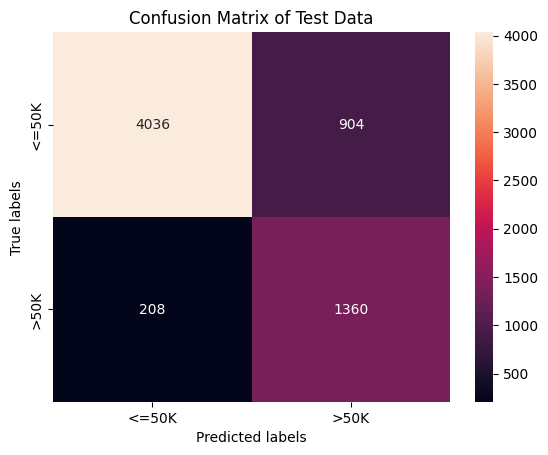

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix of Test Data')

# Project Summary
This project focused on predicting whether an individual’s annual income exceeds $50,000 based on census data from the UCI Adult dataset. The goal was to build a reliable classification model that can accurately distinguish income brackets using a mix of demographic and employment-related features.

Data cleaning involved addressing missing values marked with '?' and engineering a new feature, net capital gain/loss, which was incorporated into a preprocessing pipeline to enhance model input. The dataset showed moderate class imbalance, which was effectively managed by applying the class_weight='balanced' parameter in the models, avoiding the need for synthetic oversampling techniques like SMOTE.

Several models were evaluated, including Random Forest, Gradient Boosting, XGBoost, Logistic Regression, and LightGBM. While Logistic Regression and XGBoost provided valuable insights into feature importance, LightGBM outperformed others in terms of predictive accuracy and overall balance between precision and recall. The final model pipeline combined thorough preprocessing with tuned hyperparameters for LightGBM, resulting in strong generalization on both training and test sets.

Overall, this project demonstrated effective data preparation, model comparison, and evaluation strategies on a real-world dataset, culminating in a robust income prediction model suitable for further deployment or analysis.